# Binary-Long Term Short Memory

## A little bit of theory

###  Recurrent Neural Networks:
    
Useful when there are sequance data (ex. speech recongition, named entities recognition, sentiment classification from sentence, generation of music). Sequence data may be only the input data, the output data, ot both of them.

We cannot use a normal neural network for this because the lenght of the given sentences varies, so we do not have a fixed size for the initial and final layers. Moreover is difficult to share features which appear in different positions of the text.

So, **IDEA**: When we try to predict one word label or tag, we do not use just the given word, but also some provious knowledge coming from the previous part of the phrase.

<img src="Images/rnn.png" alt="drawing" style="width:400px;"/>


So we can use them to predict words in a sentence, given the previous words we read.
Activation function between layers is often a tanh, while the one for the output is often a sigmoid.
Each block here is defined to be a "time step".

**Problem**: it predicts the output of words in a sentence only taking infromations form the "past".
(In our case we do not have the problem that input length and output lenght have to be different)

#### So we Introduce Backpropagation

---

### Vanishing gradient problem:

Language can have a long term dependencies: what cames now in the phrase can depend on what there was in the phrase 100 words ago.

Basic RNN are not good in capturing long term dependencies because of the vanishing gradient problem: if we have a long network (=long sentence in our case), it can be difficult for the gradient to backpropagate because of the propagation of the errors. So the values of a certain outcome are influenced only by the neighbors, and not by far words.

### Introduction of Gated Recurrent Units:


<img src="Images/gru.png" alt="drawing" style="width:600px;"/>

We compute the value for a memory cell which has a value in dependence for exaple that the subject is singular or plural. This cell actually outputs an activation value ($h_t$). At each step we consider to rewrite the value of the memory cell with the candidate $\tilde h_t$, computed with the value of the previous cell and the current $x_t$. 

Then we compute the **Gate function $z_t$**, which outputs a value between 0 or 1 (which actually is relly really near or to 0 or to 1 because of the sigmoid function). The Gate decides if we will actually update $h_t$ using $\tilde h_t$ or not. If the Gate value is 1 we will replace it (look last function). The update happens then when the information we are memorizing it is not needed anymore, so we can forget about it.

In the calculations we can see that there is one addittive Gate $r_t$ which stands for the relavance of the Gate.

The GRU is made like this because it is robust and useful for many different problems.


### introduction of LSTM Units:

LSTM is a more powerful and more general version than GRU.<br>
(The original paper is onr of the most difficult to read!)

Here the main difference is that we do not have a single Gate to update the value of the memory cell, but **three different update Gates**. The first two are used in the computation of $c_t$. Those are $i_t$, which is the same of before, and $f_t$ which represents the forget gate for the previous value of the memory call.

Then the output value for $h_t$ is given by $c_t$ multiplyied for a last Gate function.

<img src="Images/lstm.png" alt="drawing" style="width:600px;"/>


The idea is that we have those new cells which allow us to keep the memory for certain values. Those cells cotain 0 / 1 values inside a matrix, which mean that we are memorizing or not a thing. At each time step we are updating the values of some functions which allow us to decide if we want to keep or delete the memory for a certain thing.

**Example**: The cat already ate, ..., was full.
At the beginning, we decide to memorize the fact that "the" in the phrase relate to a single subject. Then we memorize it until we need it again in the "was", to remember that we are referring to the single subject again. At the end of the phrase (where maybe a new phrase begins) we can forget it.

---

### Bidirectionality

Sometimes it is not enough to know what is there in the sentence before the word we are considering, to understand if it is a personal noun or whatever we are searching for. (example: "teddy" may belong to "teddy bears" or "teddy the president")


In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras_contrib import losses

from sklearn.model_selection import train_test_split

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

from collections import defaultdict

import string

Using TensorFlow backend.


In [2]:
def load_obj(name):
    with open('saved_things/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name):
    with open('saved_things/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [3]:
tagged_sentences = load_obj("tagged_sentences_100000")
words = load_obj("words_100000")

In [4]:
# max length of the sentences
max_len = 0 
for i in tagged_sentences:
    if len(i) > max_len:
        max_len = len(i)
        
max_len

117

In [5]:
# moving words and tags to indices to use them in the network as integer numbers
tags = ['O', 'B-aroma', 'B-taste', 'B-fruit', 'I-aroma', 'I-taste', 'I-fruit']

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

n_tags = len(tags)
n_words = len(words)

print(word2idx['fruit'])
print(tag2idx["B-aroma"])

4
1


In [6]:
print(n_words)
print(list(word2idx.keys())[list(word2idx.values()).index(14740)]) 

14740
ENDPAD


In [7]:
# sentences becomes a list of indices then, an so do tags:
X = [[word2idx[w[0]] for w in s] for s in tagged_sentences]
y = [[tag2idx[w[2]] for w in s] for s in tagged_sentences]

# pad_sequences: This function transforms a list of num_samples sequences (lists of integers) into a 
# 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, 
# or the length of the longest sequence otherwise.

#With padding I put each sentence with the same length. it should add "ENDPAD" as addittive words
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words)

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

y = [to_categorical(i, num_classes=n_tags) for i in y]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [8]:
len(X_tr[0])

117

In [9]:
inputt = Input(shape=(max_len,))

# Embedding layer turns positive integers (indexes) into dense vectors of fixed size. 
# eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
model = Embedding(input_dim=n_words+1, output_dim=max_len, input_length=max_len)(inputt) # output_dim=50

# Dropout: randomly setting a fraction of input units to 0 
# at each update during training time; helps prevent overfitting.
model = Dropout(0.1)(model)

# Our Bidirectional LSTM model :D
# 100 is the dimension of the output space, default activation function tanh
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Timedistributed wrapper applies a layer to every temporal slice of an input.
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [10]:
model = Model(inputt, out)

In [11]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
model.summary()

# 'None' means that the first dimension of the model is variable: it is the batch size which is not fixed 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 117)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 117, 117)          1724697   
_________________________________________________________________
dropout_1 (Dropout)          (None, 117, 117)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 117, 200)          174400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 117, 7)            1407      
Total params: 1,900,504
Trainable params: 1,900,504
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=2, validation_split=0.3, verbose=1)

Train on 6300 samples, validate on 2700 samples
Epoch 1/2
6300/6300 [==============================] - 250s 40ms/step - loss: 0.1397 - acc: 0.9639 - val_loss: 0.0596 - val_acc: 0.9776
Epoch 2/2
6300/6300 [==============================] - 220s 35ms/step - loss: 0.0471 - acc: 0.9821 - val_loss: 0.0439 - val_acc: 0.9827


In [38]:
#save_obj(history, "history_BiLSTM")
#history = load_obj("history_BiLSTM")

In [29]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_acc,loss,acc
0,0.060639,0.977366,0.141013,0.965318
1,0.042474,0.983444,0.046609,0.982070


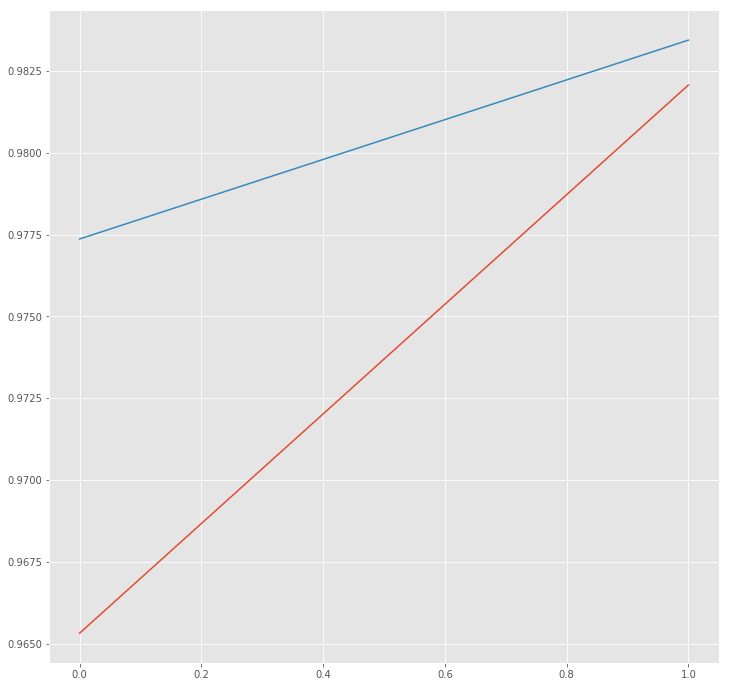

In [30]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [78]:
# serialize model to JSON

model_json = model.to_json()
with open("saved_things/model.json", "w") as json_file:
    json_file.write(model_json)

## Predictions

In [76]:
i = 19
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
this           : O     O
lacks          : O     O
a              : O     O
bit            : O     O
of             : O     O
midpalate      : O     O
richness       : O     O
but            : O     O
otherwise      : O     O
offers         : O     O
fine           : O     O
drinking       : O     O
clove          : B-aroma B-aroma
cinnamon       : B-aroma O
and            : O     O
leather        : B-aroma B-aroma
complexities   : O     O
keep           : O     O
the            : O     O
cherry         : O     O
flavors        : O     O
interesting    : O     O
while          : O     O
the            : O     O
finish         : B-taste B-taste
is             : O     O
clean          : O     O
and            : O     O
crisp          : O     O
drink          : O     O
now            : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O  

# LSTM-CRF

In [80]:
inputt = Input(shape = (max_len,))
model2 = Embedding(input_dim=n_words + 1, output_dim=20, input_length=max_len, mask_zero=True)(inputt)  # 20-dim embedding
model2 = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model2)  # variational biLSTM
model2 = TimeDistributed(Dense(50, activation="relu"))(model2)  # a dense layer as suggested by neuralNer

# Applying CRF after Bi-LSTM, after timedistributed layer
crf = CRF(n_tags)  # CRF layer
out = crf(model2) 

In [81]:
model2 = Model(inputt, out)

In [82]:
model2.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[crf.accuracy]) #crf.loss_function losses.crf_loss

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [83]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 117)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 117, 20)           294820    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 117, 100)          28400     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 117, 50)           5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 117, 7)            420       
Total params: 328,690
Trainable params: 328,690
Non-trainable params: 0
_________________________________________________________________


In [84]:
history2 = model2.fit(X_tr, np.array(y_tr), batch_size=32, epochs=2, validation_split=0.3, verbose=1)

Train on 6300 samples, validate on 2700 samples
Epoch 1/2
6300/6300 [==============================] - 120s 19ms/step - loss: 0.1693 - crf_viterbi_accuracy: 0.9638 - val_loss: 0.0797 - val_crf_viterbi_accuracy: 0.9736
Epoch 2/2
6300/6300 [==============================] - 117s 19ms/step - loss: 0.0619 - crf_viterbi_accuracy: 0.9763 - val_loss: 0.0500 - val_crf_viterbi_accuracy: 0.9801


In [41]:
#save_obj(history2, "history_BiLSTM_CRF")
#history2 = load_obj("history_BiLSTM_CRF")

In [85]:
hist2 = pd.DataFrame(history2.history)
hist2

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.079682,0.973590,0.169334,0.963805
1,0.050005,0.980076,0.061909,0.976298


The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states

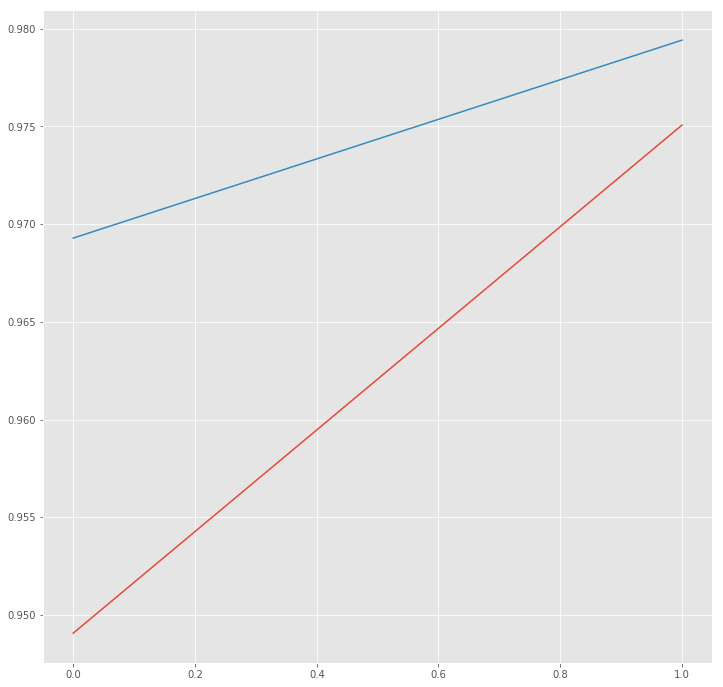

In [44]:
plt.figure(figsize=(12,12))
plt.plot(hist2["crf_viterbi_accuracy"])
plt.plot(hist2["val_crf_viterbi_accuracy"])
plt.show()

In [86]:
# serialize model to JSON
model2_json = model2.to_json()
with open("saved_things/model2.json", "w") as json_file:
    json_file.write(model2_json)

# Model Evaluation

In [46]:
test_pred = model2.predict(X_te, verbose=1)

1000/1000 [==============================] - 6s 6ms/step


In [58]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

## Performance metrics

In [ ]:
from sklearn_crfsuite import metrics

In [62]:
metrics.sequence_accuracy_score(test_labels, pred_labels) # two sequences are equal at all

0.248

In [63]:
metrics.flat_accuracy_score(test_labels, pred_labels) # couts each words label alone, not all the sequence

0.9797008547008547

In [64]:
metrics.flat_fbeta_score(test_labels, pred_labels, 2, average=None)  # F2 score for each class

array([0.71705426, 0.65305372, 0.80930065, 0.26192567, 0.57595993,
       0.40128411, 0.99339743])

In [66]:
metrics.flat_recall_score(test_labels, pred_labels, average=None)

array([0.74      , 0.67362429, 0.81046931, 0.24189189, 0.56557377,
       0.35971223, 0.99327386])

In [67]:
metrics.flat_classification_report(test_labels, pred_labels) 

'              precision    recall  f1-score   support\n\n     B-aroma       0.64      0.74      0.69      2250\n     B-fruit       0.58      0.67      0.62       527\n     B-taste       0.80      0.81      0.81       554\n     I-aroma       0.39      0.24      0.30       740\n     I-fruit       0.62      0.57      0.59       244\n     I-taste       0.75      0.36      0.49       139\n           O       0.99      0.99      0.99    112546\n\n   micro avg       0.98      0.98      0.98    117000\n   macro avg       0.68      0.63      0.64    117000\nweighted avg       0.98      0.98      0.98    117000\n'

## Predictions

In [21]:
i = 19
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
this           : O     O
beautiful      : O     O
rich           : O     O
wine           : O     O
has            : O     O
yellow         : B-fruit B-fruit
fruits         : I-fruit I-fruit
and            : O     O
is             : O     O
concentrated   : O     O
tightly        : O     O
textured       : O     O
and            : O     O
conveys        : O     O
a              : O     O
ripe           : B-aroma B-aroma
character      : O     O
the            : O     O
touches        : O     O
of             : O     O
wood           : O     O
are            : O     O
just           : O     O
right          : O     O
adding         : O     O
spice          : B-aroma B-aroma
to             : O     O
the            : O     O
opulent        : O     O
fruitiness     : O     O
a              : O     O
mineral        : B-aroma B-aroma
texture        : O     O
gives          : O     O
some           : O     O
tightness      : O     O
to             : O     O
the   

# Try on OCRS

In [24]:
import json 
directory = "saved_things/"

ocrs_dict = {}
with open(directory + 'ocrs_dictionary_improved.json' ) as json_data:
    ocrs_dict = json.load(json_data)
    json_data.close()
    
    
sentences = []
for key, val in ocrs_dict.items():
    sentences.append(val.lower())

In [ ]:
# GRAPES
with open('knowledge/grapes.json') as json_data:
    grapes = json.load(json_data)
    json_data.close()
    grapes = grapes['grapes']

grapes = [i.lower() for i in grapes]
gr = [" " + grape + " " for grape in grapes]


# WINE KIND
with open('knowledge/kind.json') as json_data:
    kind = json.load(json_data)
    json_data.close()
    kind = kind['kind']

kind = [i.lower() for i in kind]
kind = [" " + i.lower()+" " for i in kind]


# ITA WINENAME
with open('knowledge/appellations-it.json') as json_data:
    winename = json.load(json_data)
    json_data.close()
    winename = winename['appellations']
    
winename = [i.lower() for i in winename]


# USA WINENAME
winename_usa_tmp = pd.read_csv('knowledge/appellations-usa.csv')
winename_usa_tmp.iloc[:,0] = winename_usa_tmp.iloc[:,0] .map(lambda x: x.replace(' AVA',''))

winename_usa = list(winename_usa_tmp.iloc[:,0])
winename_usa = [x.lower() for x in winename_usa]

ORG = ["Winery", "Company", "Companies", "Cellar"]

places = ["Missouri", "City", 'san benito county', "new york", "COLCHAGUA VALLEY", "san luis obispo",\
          "Italy", "New Zealand", "St. Louis County", "Columbia Valley", "Carolina", "Spain", "Italia", \
          "France", "Slovenija", "Australia", "Chile", "España", "USA", "Canada", "Oregon", "California",\
          "Europe", "NAPA", "Portland", "yorkville", "Santa Clara County", "monterey county", "Oakville",\
          "Walla walla", "St Helena", "santa barbara county", "Saint Helena", "New Mexico", "Manhasset"]

vineyards = ['gimelli vineyards', 'Boenker Hill Vineyard', 'edna valley vineyard', 'laetitia vineyard', \
             'Lockwood Vineyards', 'Skyfall Vineyard', 'sonoma coast vineyards', 'balletto vineyards', \
             'Becker Vineyards', 'mount baker vineyards', 'guerra vineyards', 'camelot vineyard', 'pedregal vineyard', \
             'chalone vineyard', 'adastra vineyard', 'sangiovese vineyards', 'weir vineyard', \
             'spring hill vineyards', 'adelsheim vineyard', 'gunsalus vineyard', 'leaping horse vineyards', \
             'reed vineyard', 'ADIRONDACK WINERY', 'Chapelle Winery']
vineyards = [x.lower() for x in vineyards]

In [26]:
sentences[2]

'celebre rose is a methode champenoise\nsparkling wine made from pinot meunier.\n\ndr. konstantin frank, was the first to pioneer\nquality vinifera in the eastern united states.\nfor over fifty-five years, the winery has been\namong the most prestigious in the finger lakes\nwine region of new york state. our story is\na legacy four generations in the making.\n\nproduced & bottled by\nchateau frank inc. hammondsport, n.y. 14840\n\ngovernment warning: (1) according to the surgeon\ngeneral, women should not drink alcoholic beverages\nduring pregnancy because of the risk of birth defects.\n(2) consumption of alcoholic beverages impairs your\nability to drive a car or\n\noperate machinery, and\n\nmay cause health problems.\n\n12% alc. vol.750ml\ncontains sulfites'